隔了好久終於把上次文章的第二部份產出了！

這次所做的主題延續上次的title clustering，不過我在word2vec模型的訓練上做了一點小更動。另外最重要的也加入了新的方法來衡量一個句子如何以向量形式表達。上次我所採用的方法是將一個標題中所包含的所有詞的詞向量加總後平均作為能代表這個標題的「句向量」，而這次則是加入了tfidf的概念，以每個標題的tfidf向量作為加權乘上word2vec中所有詞的詞向量來產出一個包含所有標題向量的矩陣。這樣一來每一個標題更能包含一個詞語重要性的概念。

我們趕快來看看吧

# 建立training set

這邊的步驟與上次一樣，為了方便最後做比較，我與之前使用一樣的training set，也就是來自政黑板的45則標題。

In [43]:
from gensim.models import Word2Vec
import nltk
from nltk.cluster import KMeansClusterer
import jieba
import numpy as np
  
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE

titles=[]
training_set=[]
stopWords = []
jieba.load_userdict('userdic.txt') #建立詞頻表

with open('stopWords.txt', 'r', encoding='UTF-8') as file:   #建立停用詞列表
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

with open('ptt_titles.txt', 'r', encoding='UTF-8') as file:  #叫出剛剛存下來的標題文字檔
    for data in file.readlines():
        data = data.strip()
        titles.append(data)
        
for title in titles:
    seg_list = jieba.lcut(title, cut_all=False)
    remainderWords = list(filter(lambda a: a not in stopWords and a != '\n', seg_list))   #去除停用詞
    training_set.append(remainderWords)
    
print(training_set)

[['司法院', '行政院', '是不是', '蔡英文', '講話', '放屁'], ['台灣', '禁醫護', '人員', '出國', '是不是', '先知'], ['吳介聲', '／', '美', '眾議院', '台北', '法案', '台灣'], ['滅', '不了', '柯', '可毀', '掉', '幕僚'], ['吉', 'FB', '-', '社會', '議題', '大論鬥', ' ', '(', '來賓', ':', '黃國昌', ' ', '苗博雅', ')'], ['綠畜', '邏輯', '生', '台灣', ' ', '台灣'], ['該禁', '歐洲', '旅遊團'], ['北部', '高中'], ['柯粉', '經弱', '議員', '滅團'], ['柯文哲', '陳時中', '不同'], ['吉', 'FB', '-', '社會', '議題', '大論鬥', ' ', '(', '來賓', ':', '黃國昌', ' ', '苗博雅', ')'], ['詢問', '一下', ' ', '版主', '投票', '問題'], ['王浩宇', '484', '火力', '全開', '拚', '上位'], ['政治', '黑特板', '板規', '20191119', 'V5.6'], ['賭文', '開獎', '專區', ' ', '請', '版友', '遵守', '承諾'], ['請', '提供', '推薦', '文章'], ['板主選舉', ' ', '候選人', '名單'], ['啟臣', '未', '提', '九二', '共識', ' ', '台師', '教授', '邯鄲', '學步'], ['陳揮文', ' ', '意', '唐鳳', '驢', ',', '了不起'], ['滅', '不了', '柯', '可毀', '掉', '幕僚'], ['柯', 'P', '是不是', '健忘症'], ['啟臣', '未', '提', '九二', '共識', ' ', '台師', '教授', '邯鄲', '學步'], ['爭議', '走', '沒人', '追'], ['川普', '是不是', '欠', '歐巴馬', '健保', '一個', '道歉'], ['民眾黨', '日後晚', '會', '擔任', '混音', 'DJ'], ['柯粉', '

# 建立word2vec模型：

有了training set之後便能用其訓練詞向量模型，而跟之前不同的是，我減少了模型使用的維度，只使用了5維。  
上次我沒有注意到word2vec預設的維度數量是100，導致我只有165個tokens卻要散在100個維度裡導致詞向量太稀疏了，因此經過不斷測試之後最後把維度訂在5，最後cluster會比較分明。


In [ ]:
model = Word2Vec(training_set, size = 5, min_count=1)


print(model.wv.vectors)
print(model.wv.vocab.keys())



# 產出標題向量

有了詞向量之後，就可以來計算代表每一個標題的向量了：

## 平均法

第一個方法是上一篇已經用過的平均法，這裡我也稍微做了一點改動讓code看起來比較乾淨。  
由於我將模型維度設為5，最後每個標題便會是以一個長度為5的向量來表達，而因為共有45則標題，我們可以把所有標題向量整理成一個45x5的矩陣。

In [ ]:
average=[]
for title in training_set:
    for i in range(len(title)):
        sent_vec_sum = 0
        sent_vec_sum += model[title[i]]
        sent_vec = sent_vec_sum/ len(title)
    average.append(sent_vec)
    

接下來我將上次用KMeansClusterer做clustering和TSNE做降維視覺化的部分寫成一個函數來方便後面使用：

In [68]:
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

def cluster_and_plot(X):
    NUM_CLUSTERS=2
    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
     
     
     
    kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(X)
  
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
 
    model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
 
    Y=model.fit_transform(X)
 
 
    plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=300,alpha=.5)
 
 
    for j in range(len(titles)):    
       plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
       print ("%s %s" % (assigned_clusters[j],  titles[j]))
 
 
    plt.show()


## 結果展示-平均法

1 司法院與行政院是不是把蔡英文講話當放屁
0 台灣禁醫護人員出國是不是先知？
1 吳介聲／美眾議院通過《台北法案》，台灣
0 滅不了柯，但可毀掉他的幕僚
1 吉FB-社會議題大論鬥 (來賓:黃國昌 苗博雅)
1 綠畜邏輯：生在台灣 台灣就你的？
1 該禁歐洲旅遊團嗎？
1 北部那所高中啊？
1 柯粉已經弱到被議員滅團
0 柯文哲與陳時中的不同
1 吉FB-社會議題大論鬥 (來賓:黃國昌 苗博雅)
1 詢問一下大家 版主投票問題
1 王浩宇484火力全開要拚上位?
1 政治黑特板板規_20191119_V5.6
1 對賭文開獎專區 請版友遵守承諾
0 請大家提供推薦文章
1 板主選舉 候選人名單
0 啟臣未提九二共識 台師大教授：邯鄲學步
1 陳揮文 意：唐鳳你不就是驢,有啥了不起？
0 滅不了柯，但可毀掉他的幕僚
1 柯P是不是得了健忘症啊?
0 啟臣未提九二共識 台師大教授：邯鄲學步
0 為何這些爭議人走了後就沒人在追了
1 川普是不是欠歐巴馬健保一個道歉
0 民眾黨日後晚會誰來擔任混音DJ？
1 柯粉 電音趴的經費 不瞭解一下嗎？
1 台灣社會對特殊性向仍不友好
1 為什麼我 加入不了 台北好朋友QQ
1 武漢肺炎起源在那？
1 全部禁出國很難嗎？
0 王浩宇FB－林富男：習近平好棒棒！
1 全部禁出國很難嗎？
1 新南向已經徹底失敗了嗎？
0 DPP收佛地魔和TMD找黨員的不同
0 投票重新舉行
1 2020板主選舉
1 台灣敢ban掉所有的航線嗎？
1 民眾黨還有什麼獨特性？
0 所以林飛帆跟洪慈庸是哪裡酬庸？
0 中國趕緊復工了吧！
1 大家支持死刑嗎
0 中國趕緊復工了吧！
1 國外的總理、總統、州長、市長....
1 柯粉 電音趴的經費 不瞭解一下嗎？
1 台灣社會對特殊性向仍不友好


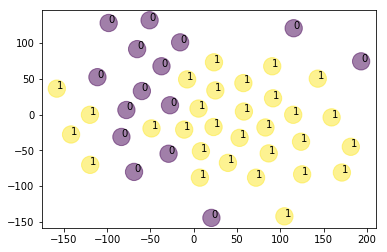

In [118]:
cluster_and_plot(average)

從圖上來看，大致上呈現兩個clusters，不過兩個cluster各有一些離群值  

## tfidf加權法

接下來使用另一個方法來計算標題向量，也就是透過tfidf加權的方式，首先我使用TfidfVectorizer來產出每一個標題的tfidf向量。  
由於我的training set總共包含165個tokens，因此每則標題需要用一個長度為165的向量來表達。  
最後45則標題可以整理成一個45x165的矩陣。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase = False)    
result = tfidf.fit_transform(training_set)

print(result.todense())



有了tfidf向量後，我把它乘上word2vec裡所包含的所有詞向量形成一個新的矩陣：
這裡我詳細說明一下：我在word2vec中設定的維度是5，而因為我有165個tokens，所以所有的詞向量可以用一個165x5的矩陣表達  
而tfidf向量是一個45x165的矩陣，因此把兩個矩陣相乘後，會形成一個45x5的矩陣，每一列代表一個標題，而每個標題剛好就是用一個長度為5的向量表達，跟平均法的矩陣形狀是一樣的。

In [ ]:
tfidf_weighted = np.dot(result.todense() ,model.wv.vectors)
print(tfidf_weighted)

## 結果展示-tfidf加權法

1 司法院與行政院是不是把蔡英文講話當放屁
1 台灣禁醫護人員出國是不是先知？
1 吳介聲／美眾議院通過《台北法案》，台灣
0 滅不了柯，但可毀掉他的幕僚
1 吉FB-社會議題大論鬥 (來賓:黃國昌 苗博雅)
0 綠畜邏輯：生在台灣 台灣就你的？
1 該禁歐洲旅遊團嗎？
1 北部那所高中啊？
0 柯粉已經弱到被議員滅團
0 柯文哲與陳時中的不同
1 吉FB-社會議題大論鬥 (來賓:黃國昌 苗博雅)
0 詢問一下大家 版主投票問題
1 王浩宇484火力全開要拚上位?
1 政治黑特板板規_20191119_V5.6
0 對賭文開獎專區 請版友遵守承諾
1 請大家提供推薦文章
1 板主選舉 候選人名單
0 啟臣未提九二共識 台師大教授：邯鄲學步
1 陳揮文 意：唐鳳你不就是驢,有啥了不起？
0 滅不了柯，但可毀掉他的幕僚
1 柯P是不是得了健忘症啊?
0 啟臣未提九二共識 台師大教授：邯鄲學步
0 為何這些爭議人走了後就沒人在追了
1 川普是不是欠歐巴馬健保一個道歉
1 民眾黨日後晚會誰來擔任混音DJ？
0 柯粉 電音趴的經費 不瞭解一下嗎？
0 台灣社會對特殊性向仍不友好
1 為什麼我 加入不了 台北好朋友QQ
1 武漢肺炎起源在那？
0 全部禁出國很難嗎？
1 王浩宇FB－林富男：習近平好棒棒！
0 全部禁出國很難嗎？
0 新南向已經徹底失敗了嗎？
1 DPP收佛地魔和TMD找黨員的不同
0 投票重新舉行
0 2020板主選舉
1 台灣敢ban掉所有的航線嗎？
1 民眾黨還有什麼獨特性？
0 所以林飛帆跟洪慈庸是哪裡酬庸？
1 中國趕緊復工了吧！
0 大家支持死刑嗎
1 中國趕緊復工了吧！
1 國外的總理、總統、州長、市長....
0 柯粉 電音趴的經費 不瞭解一下嗎？
0 台灣社會對特殊性向仍不友好


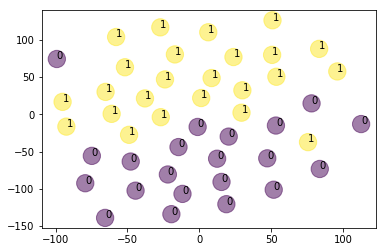

In [123]:
cluster_and_plot(np.array(tfidf_weighted))

可以看到相比平均法，離群值的數量減少了一些，且可以明顯看出上下兩個不同cluster。  

最後來檢視一下word2vec的缺點：雖說word2vec比起純粹的one-hot encoding更融入了字更字之間的語意關係，但從句子的角度來看，word2vec依舊沒有辦法考量到句子中的字詞順序，不管是平均法或是tfidf加權法，字詞的順序都會被忽略掉。  

不過字詞順序對於語意表達是非常重要的，因此後來Mikolov又提出了doc2vec這個工具，是以句子或段落作為單位來賦予向量，如此一來詞語的順序就會被列入考量。但doc2vec可能要等未來有機會再來試試了，可能可以與我之後想做的title classification結合一下。

那這篇就到這裡了！謝謝大家閱讀～

附上一些參考資料：  
tfidf的計算：https://sanjayasubedi.com.np/nlp/nlp-feature-extraction/
tfidf跟word vectors的組合：http://www.crownpku.com/2018/04/15/Weighted-Word-Vector-with-respect-to-TF-IDF.html